<a href="https://colab.research.google.com/github/MasoudMoeini/Google-Street-View-Images-Blur-Detection/blob/main/SBDN_Ablation_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential, Model,load_model
from keras.optimizers import gradient_descent_v2 
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from keras import regularizers

In [ ]:
!unzip -qq shi800train.zip

In [ ]:
!unzip -qq shi800train-gt.zip

In [ ]:
from numpy import *
images_folder= "shi800train/*"
labels_folder = "shi800train-gt/"
def data_preprocessing(images_folder,labels_folder):
  total_img = []
  label = []
  files = glob.glob (images_folder)
  for myFile in files:
      image_name=os.path.split(myFile)[1]
      # image resize
      image = Image.open(myFile)
      image = image.resize((224, 224))
      image = np.asarray(image)
      total_img.append(image)
      #Gt
      image_name=image_name[:-3]
      image_name=image_name+'png'
      label_image = Image.open(labels_folder+image_name)
      label_image = label_image.resize((224, 224))
      label_image = np.asarray(label_image)
      if (label_image.shape!=(224,224)):
        label_image=label_image[:,:,0]
      label.append (label_image)
  total_img = np.array(total_img)
  label = np.array(label)
  label= np.reshape(label,[label.shape[0],label.shape[1],label.shape[2]])
  total_img= np.reshape(total_img,[total_img.shape[0],total_img.shape[1],total_img.shape[2],total_img.shape[3]]) 
  return label,total_img

In [ ]:
CHUK_labels,CHUK_images=data_preprocessing(images_folder,labels_folder)

In [ ]:
CHUK_images.shape

(800, 224, 224, 3)

In [ ]:
CHUK_labels.shape

(800, 224, 224)

In [ ]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def decoder_network(HLSF):
  # 7*7*2048 is input tensor 
  #decoder 
  dec2 = layers.Conv2DTranspose(2048, (3, 3), strides=2, activation="relu", padding="same")(HLSF) #14*14*2048
  dec3 = layers.Conv2DTranspose(512, (3, 3), strides=2, activation="relu", padding="same")(dec2)#28*28*512
  dec4 = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(dec3)#56*56*128
  dec5 = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(dec4)#112*112*32
  dec6 = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(dec5)#224*224*3
  dec7 = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="relu",padding="same")(dec6)#224*224*1
  dec8 = layers.Conv2DTranspose(1, (3, 3), strides=1, activation="relu",padding="same",name='DecBM')(dec7)#224*224*1
  #FusionNetwork1
  #Upsam_Deep1 = layers.Conv2DTranspose(128, (3, 3), strides=32, activation="relu", padding="same")(HLSF)
  #Upsam_Deep2 = layers.Conv2DTranspose(128, (3, 3), strides=16, activation="relu", padding="same")(dec2)
  #Upsam_Deep3 = layers.Conv2DTranspose(128, (3, 3), strides=8, activation="relu", padding="same")(dec3)
  #concatted_deep = tf.keras.layers.Concatenate(axis=3)([Upsam_Deep1,Upsam_Deep2,Upsam_Deep3])
  #result_concatted_deep= layers.Conv2D(1, (1, 1), strides=1, activation="relu", padding="same",name='HLBM')(concatted_deep) #224*224*1
  #FusionNetwork2
  Upsam_Shallow1=layers.Conv2DTranspose(16, (3, 3), strides=4, activation="relu", padding="same")(dec4)
  Upsam_Shallow2=layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(dec5)
  concatted_Shallow = tf.keras.layers.Concatenate()([Upsam_Shallow1,Upsam_Shallow2,dec6])
  result_concatted_Shallow= layers.Conv2D(1, (1, 1), strides=1, activation="relu", padding="same",name='LLBM')(concatted_Shallow) #224*224*1
  #Concatenate all results
  concatted_all = tf.keras.layers.Concatenate()([dec8,result_concatted_Shallow])
  final_output= layers.Conv2D(1, (1, 1), strides=1, activation="sigmoid", padding="same",kernel_regularizer=regularizers.L2(l2=0.005),
      bias_regularizer=regularizers.L2(l2=0.0005),name='FBME')(concatted_all) #224*224*1
  return final_output

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [ ]:
def ResNet50():
    X_input = layers.Input(shape=(224, 224, 3))
    X = data_augmentation(X_input)
    X = layers.Rescaling(1./255)(X)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    #7*7*2048
    output1=decoder_network(X)
    #X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    #X = Flatten()(X)
    #X = Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(X)
    #X = Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(X)
    #main = Dense( 1,activation='sigmoid', name='main',kernel_initializer=glorot_uniform(seed=0))(X)
    model = Model(inputs=X_input, outputs=output1, name='ResNet50')
    return model

In [ ]:
model= ResNet50()
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d_1[0][0]']       
                                )                                                          

In [ ]:
class StopOnPoint(tf.keras.callbacks.Callback):
    def __init__(self, point):
        super(StopOnPoint, self).__init__()
        self.point = point
    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["accuracy"]
        if accuracy >= self.point:
            self.model.stop_training = True
callbacks = [StopOnPoint(0.995)]

In [ ]:
loss1=tf.keras.losses.MeanSquaredError()
model.compile(keras.optimizers.Adam(learning_rate=1e-3),loss = [loss1],metrics=["accuracy"])

In [ ]:
x_train = CHUK_images.astype(np.float32)/ 255.0
y_train=CHUK_labels.astype(np.float32)/ 255.0
y_train=np.where(y_train>0.5,1.0,0.0)
y_train=(y_train)

In [ ]:
history = model.fit(x_train,y_train, epochs=120,batch_size=25, validation_split=0.0,shuffle=True,callbacks=[callbacks])
model.save('sbdn-ablation-02-shallow-model.h5')

Epoch 1/120
32/32 [==============================] - 37s 607ms/step - loss: 0.2361 - accuracy: 0.6096
Epoch 2/120
32/32 [==============================] - 20s 615ms/step - loss: 0.2078 - accuracy: 0.6478
Epoch 3/120
32/32 [==============================] - 20s 625ms/step - loss: 0.1898 - accuracy: 0.7219
Epoch 4/120
32/32 [==============================] - 20s 621ms/step - loss: 0.1824 - accuracy: 0.7374
Epoch 5/120
32/32 [==============================] - 20s 614ms/step - loss: 0.1680 - accuracy: 0.7624
Epoch 6/120
32/32 [==============================] - 20s 616ms/step - loss: 0.1687 - accuracy: 0.7586
Epoch 7/120
32/32 [==============================] - 20s 620ms/step - loss: 0.1689 - accuracy: 0.7630
Epoch 8/120
32/32 [==============================] - 20s 619ms/step - loss: 0.1627 - accuracy: 0.7716
Epoch 9/120
32/32 [==============================] - 20s 617ms/step - loss: 0.1587 - accuracy: 0.7795
Epoch 10/120
32/32 [==============================] - 20s 618ms/step - loss: 0.160

In [ ]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy'])


In [ ]:
model = load_model("sbdn-ablation-02-shallow-model.h5")

In [ ]:
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_csv_file = 'sbdn-shi-history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

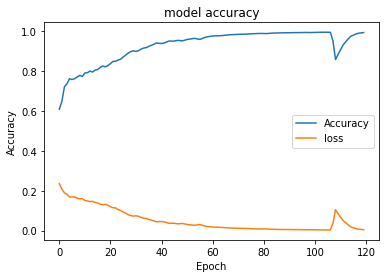

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
#plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","loss"])
plt.show()

In [ ]:
!unzip -qq shi200test.zip
!unzip -qq shi200test-gt.zip

In [ ]:
images_folder= "shi200test/*"
labels_folder = "shi200test-gt/"
def data_preprocessing(images_folder,labels_folder):
  total_img = []
  label = []
  labels_identities=[]
  files = glob.glob (images_folder)
  for myFile in files:
      image_name=os.path.split(myFile)[1]
      # image resize
      image = Image.open(myFile)
      image = image.resize((224, 224))
      image = np.asarray(image)
      total_img.append(image)
      #Gt
      image_name=image_name[:-3]
      image_name=image_name+'png'
      labels_identities.append(image_name)
      label_image = Image.open(labels_folder+image_name)
      label_image = label_image.resize((224, 224))
      label_image = np.asarray(label_image)
      if (label_image.shape!=(224,224)):
        label_image=label_image[:,:,0]
      label.append (label_image)
  total_img = np.array(total_img)
  label = np.array(label)
  label= np.reshape(label,[label.shape[0],label.shape[1],label.shape[2]])
  total_img= np.reshape(total_img,[total_img.shape[0],total_img.shape[1],total_img.shape[2],total_img.shape[3]]) 
  return label,total_img,labels_identities

In [ ]:
eval_labels,eval_images,labels_names=data_preprocessing(images_folder,labels_folder)

In [ ]:
eval_images.shape

(200, 224, 224, 3)

In [ ]:
eval_labels.shape

(200, 224, 224)

In [ ]:

from keras.models import load_model
from PIL import Image
images = eval_images
predictions=[]
for i in range(images.shape[0]):
  img = images[i]
  img = img.astype(np.float32)/ 255.0
  img = np.expand_dims(img, -1)
  img = np.expand_dims(img, 0)
  pred = model.predict(img)
  predictions.append(pred)

In [ ]:
len(predictions)

200

## **Evaluation with Shi et al (Chuk) Dataset**

## Instantiate Optimal Threshould for Evaluation Ground Truths

In [ ]:
ground_truth_total=eval_labels/255.0
ground_truth_total=np.where(ground_truth_total>0.5,1.0,0.0)

In [ ]:
pred_labels_total=[]
for i in range(len(predictions)):
  hh = (predictions[i])[0]
  hh = hh[:,:,0]
  pred_labels_total.append(hh)
pred_labels_total=np.array(pred_labels_total)

## Mean Absolute Error

In [ ]:
def get_mae(true_label, y_pred_label):
  absolute_error=[]
  for i in range(0,len(true_label)):
    y_pred = np.where(y_pred_label[i]>0.5,1.0,0.0)
    y_true=true_label[i]
    mae = tf.keras.losses.MeanAbsoluteError()
    m = mae(y_true, y_pred).numpy()
    absolute_error.append(m)
  return mean(absolute_error)
mean_absolute_error= get_mae(ground_truth_total,pred_labels_total)
print('Mean Absolute Error for Evaluation set: ',mean_absolute_error)

Mean Absolute Error for Evaluation set:  0.19162139269770406


## Average Optimal Image Scale OIS-F score

In [ ]:
from sklearn.metrics import precision_score,recall_score
threshoulds=[0.3,0.4,0.5,0.6,0.7]
beta2=0.2
def recall_precison(y_true,y_pred):
  OIS_F=[]
  Fb=[]
  for i in range(0,len(y_pred)):
    OIS_F_thr=[]
    fb_thr=[]
    for thr in threshoulds:
      pr=np.where(y_pred[i]>thr,1.0,0.0)
      #pr=reshape(pr,[224,224])
      pred_precision_score=precision_score(y_true[i],pr, average='weighted')
      pred_recall_score=recall_score(y_true[i],pr, average='weighted')
      OIS=2*pred_precision_score*pred_recall_score/(pred_precision_score+pred_recall_score)
      fb=(1+beta2)*pred_precision_score*pred_recall_score/(beta2 * pred_precision_score+pred_recall_score)
      fb_thr.append(fb)
      OIS_F_thr.append(OIS)
    Fb.append(fb_thr)
    OIS_F.append(OIS_F_thr)
  return OIS_F,Fb

In [ ]:
OIS_array,Fb_array=recall_precison(ground_truth_total,pred_labels_total)

In [ ]:
def Fb_score(Fb_array):
  best_Fb=[]
  for results in Fb_array:
    f_score=max(results)
    best_Fb.append(f_score)
  return np.nanmean(best_Fb)
mean_Fb_score= Fb_score(Fb_array)
print('F-measure score: ',mean_Fb_score)

F-measure score:  0.8424901352383395


In [ ]:
def OIS_F_score(OIS_array):
  best_OIS_F=[]
  index_max=[]
  for results in OIS_array:
    f_score=max(results)
    best_OIS_F.append(f_score)
    index = results.index(f_score)
    index_max.append(index)
  return best_OIS_F,index_max
OIS_f1,indexes=OIS_F_score(OIS_array)
print('Average Optimal Image Scale F score: ',np.nanmean(OIS_f1))

Average Optimal Image Scale F score:  0.8324023558547395


## Precision Recall Graph

In [ ]:
Y_ts_pred =reshape(predictions,[len(predictions),224,224])
Y_ts_pred = Y_ts_pred.reshape(Y_ts_pred.shape[0]*Y_ts_pred.shape[1]*Y_ts_pred.shape[2], 1)
print(Y_ts_pred.shape)
Y_ts = ground_truth_total.reshape(ground_truth_total.shape[0]*ground_truth_total.shape[1]*ground_truth_total.shape[2], 1)
print(Y_ts.shape)
Y_ts_pred = np.where(Y_ts_pred>0.5, 1, 0)
Y_ts  = np.where(Y_ts>0.5, 1, 0)

(10035200, 1)
(10035200, 1)



Area under Precision-Recall curve: 0.9031424522307994
Average Precision Scores: 0.8261098155868931


<Figure size 432x288 with 0 Axes>

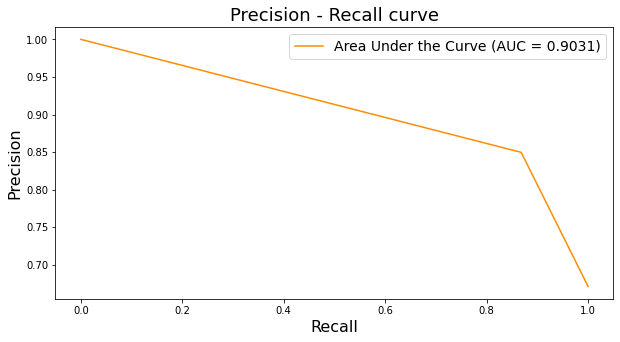

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import numpy as np
import matplotlib.pyplot as plt
precision, recall, thresholds = precision_recall_curve(Y_ts, Y_ts_pred)
average_precision = average_precision_score(Y_ts, Y_ts_pred)
precision = np.fliplr([precision])[0]  #to avoid getting negative AUC)
recall = np.fliplr([recall])[0]  #to avoid getting negative AUC)
AUC_prec_rec = np.trapz(precision,recall)
print("\nArea under Precision-Recall curve: " +str(AUC_prec_rec))
prec_rec_curve = plt.figure()
plt.figure(figsize=(10,5))
plt.plot(recall,precision,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec,color="darkorange")
plt.title('Precision - Recall curve',fontsize=18)
plt.xlabel("Recall",fontsize=16)
plt.ylabel("Precision",fontsize=16)
plt.legend(loc="best",prop={'size': 14})
plt.savefig("Precision_recall.png")
print("Average Precision Scores: " +str(average_precision))

In [ ]:
beta2=0.3
fb=(1+beta2)*precision[1]*recall[1]/((beta2 * precision[1])+recall[1])
fb

0.8538381138896576

## **Evaluation with DUT Dataset**

In [ ]:
!unzip -qq dut500-source.zip

In [ ]:
!unzip -qq dut500-gt.zip

In [ ]:
from numpy import *
images_folder= "dut500-source/*.bmp"
labels_folder = "dut500-gt/"
def data_preprocessing(images_folder,labels_folder):
  total_img = []
  label = []
  files = glob.glob (images_folder)
  for myFile in files:
      image_name=os.path.split(myFile)[1]
      img = Image.open(myFile)
      new_img = img.resize( (224, 224))
      image = array(new_img)
      new_label=Image.open(labels_folder+image_name)
      new_label = new_label.resize((224, 224))
      label_image = array(new_label)
      label.append (label_image)
      total_img.append (image)
  total_img = np.array(total_img)
  label = np.array(label)
  label= np.reshape(label,[label.shape[0],label.shape[1],label.shape[2]])
  total_img= np.reshape(total_img,[total_img.shape[0],total_img.shape[1],total_img.shape[2],total_img.shape[3]])
  return label,total_img

In [ ]:
DUT_labels,DUT_images=data_preprocessing(images_folder,labels_folder)

In [ ]:
DUT_images.shape

(500, 224, 224, 3)

In [ ]:
DUT_labels.shape

(500, 224, 224)

In [ ]:
from keras.models import load_model
from PIL import Image
images = DUT_images
predictions=[]
for i in range(images.shape[0]):
  img = images[i]
  img = img.astype(np.float32)/ 255.0
  img = np.expand_dims(img, -1)
  img = np.expand_dims(img, 0)
  pred = model.predict(img)
  predictions.append(pred)

In [ ]:
ground_truth_total=DUT_labels/255.0
ground_truth_total=np.where(ground_truth_total>0.5,0.0,1.0)

In [ ]:
def get_mae(true_label, y_pred_label):
  absolute_error=[]
  for i in range(0,len(true_label)):
    #true_label = eval_labels[i]/255.0
    pp=np.where(((y_pred_label[i])[0])>0.5,1.0,0.0)
    y_pred=reshape(pp,[224,224])
    y_true=true_label[i]
    mae = tf.keras.losses.MeanAbsoluteError()
    m = mae(y_true, y_pred).numpy()
    absolute_error.append(m)
  return mean(absolute_error)
mean_absolute_error= get_mae(ground_truth_total,predictions)
print('Mean Absolute Error for Evaluation set: ',mean_absolute_error)

Mean Absolute Error for Evaluation set:  0.16480955038265307


## Precision-Recall 

In [ ]:
Y_ts_pred =reshape(predictions,[len(predictions),224,224])
Y_ts_pred = Y_ts_pred.reshape(Y_ts_pred.shape[0]*Y_ts_pred.shape[1]*Y_ts_pred.shape[2], 1)
print(Y_ts_pred.shape)
Y_ts = ground_truth_total.reshape(ground_truth_total.shape[0]*ground_truth_total.shape[1]*ground_truth_total.shape[2], 1)
print(Y_ts.shape)
Y_ts_pred = np.where(Y_ts_pred>0.5, 1, 0)
Y_ts  = np.where(Y_ts>0.5, 1, 0)

(25088000, 1)
(25088000, 1)



Area under Precision-Recall curve: 0.9142959737440616
Average Precision Scores: 0.8399384094198149


<Figure size 432x288 with 0 Axes>

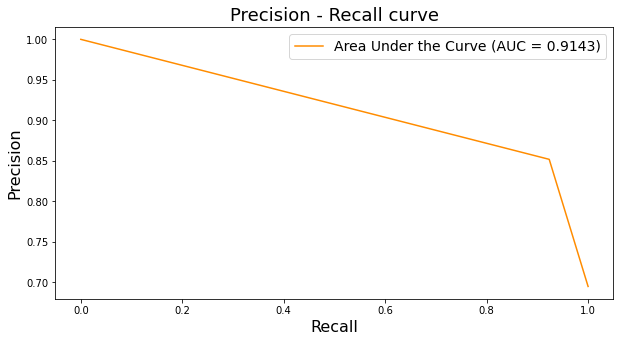

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import numpy as np
import matplotlib.pyplot as plt
precision, recall, thresholds = precision_recall_curve(Y_ts, Y_ts_pred)
average_precision = average_precision_score(Y_ts, Y_ts_pred)
precision = np.fliplr([precision])[0]  #to avoid getting negative AUC)
recall = np.fliplr([recall])[0]  #to avoid getting negative AUC)
AUC_prec_rec = np.trapz(precision,recall)
print("\nArea under Precision-Recall curve: " +str(AUC_prec_rec))
prec_rec_curve = plt.figure()
plt.figure(figsize=(10,5))
plt.plot(recall,precision,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec,color="darkorange")
plt.title('Precision - Recall curve',fontsize=18)
plt.xlabel("Recall",fontsize=16)
plt.ylabel("Precision",fontsize=16)
plt.legend(loc="best",prop={'size': 14})
plt.savefig("Precision_recall.png")
print("Average Precision Scores: " +str(average_precision))

In [ ]:
beta2=0.3
fb=(1+beta2)*precision[1]*recall[1]/((beta2 * precision[1])+recall[1])
fb

0.8674369790886218

In [ ]:
from sklearn.metrics import precision_score,recall_score
threshoulds=[0.3,0.4,0.5,0.6,0.7]
beta2=0.2
def recall_precison(y_true,y_pred):
  OIS_F=[]
  Fb=[]
  for i in range(0,len(y_pred)):
    OIS_F_thr=[]
    fb_thr=[]
    for thr in threshoulds:
      pr=np.where(((y_pred[i])[0])>thr,1.0,0.0)
      pr=reshape(pr,[224,224])
      pred_precision_score=precision_score(y_true[i],pr, average='weighted')
      pred_recall_score=recall_score(y_true[i],pr, average='weighted')
      OIS=2*pred_precision_score*pred_recall_score/(pred_precision_score+pred_recall_score)
      fb=(1+beta2)*pred_precision_score*pred_recall_score/(beta2 * pred_precision_score+pred_recall_score)
      fb_thr.append(fb)
      OIS_F_thr.append(OIS)
    Fb.append(fb_thr)
    OIS_F.append(OIS_F_thr)
  return OIS_F,Fb

In [ ]:
OIS_array,Fb_array=recall_precison(ground_truth_total,predictions)

In [ ]:
def Fb_score(Fb_array):
  best_Fb=[]
  for results in Fb_array:
    f_score=max(results)
    best_Fb.append(f_score)
  return np.nanmean(best_Fb)
mean_Fb_score= Fb_score(Fb_array)
print('Fb score: ',mean_Fb_score)

Fb score:  0.8896259694277624


In [ ]:
def OIS_F_score(OIS_array):
  best_OIS_F=[]
  index_max=[]
  for results in OIS_array:
    f_score=max(results)
    best_OIS_F.append(f_score)
    index = results.index(f_score)
    index_max.append(index)
  return best_OIS_F,index_max
OIS_f1,indexes=OIS_F_score(OIS_array)
print('Average Optimal Image Scale F score: ',np.nanmean(OIS_f1))

Average Optimal Image Scale F score:  0.9002774455047008
